# Clustering by Compression

<https://homepages.cwi.nl/~paulv/papers/cluster.pdf>

<https://parezcoydigo.wordpress.com/2011/10/09/clustering-with-compression-for-the-historian/>

<https://github.com/MLWave/koolmogorov>

## Calcul de la distance

In [1]:
from lzma import compress

def dist(f1:str, f2:str) -> float:
    '''
    f1 et f2 sont les chemins d'accès de deux fichiers à comparer.
    La fonction retourne une distance d'information mutuelle normalisée, entre 0 et 1.
    '''
    x,y = open(f1,'rb').read(),open(f2,'rb').read()
    Ix,Iy = len(compress(x)),len(compress(y))
    Ixy = len(compress(x+y))
    return (Ixy-min(Ix,Iy))/max(Ix,Iy)

## Liste des fichiers

In [2]:
from os import scandir

def file_list(path:str='files/') -> list[str]:
    '''
    path est le chemin du dossier contenant les fichiers à comparer, par défaut le dans le dossier files.
    La fonction retourne la liste des fichiers dans ce dossier.
    '''
    if path[-1] != '/':
        path+='/'
    return [path+file.name for file in scandir(path)]

## Calcul et affichage de la matrice de distances

In [3]:
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

def dist_matrix_legacy(path:str='files/') -> np.ndarray:
    '''
    Calcule la matrice des distances des fichiers dans le répertoire indiqué par path.
    '''
    FILES = file_list(path)
    n = len(FILES)
    
    t = tqdm(total = n*(n-1)//2,miniters=1,desc='Construction de la matrice de distances : ')
        
    D = np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            D[i,j]=dist(FILES[i],FILES[j]) 
            D[j,i]=D[i,j]
            
            # Sous-optimal : chaque fichier est compressé n fois au lieu d'une seule.
            # Pas catastrophique : ne ferait que changer la complexité totale d'un facteur ~3.
            # Idée : commencer par la matrices des longueurs, avec len(compress(x)) sur la diagonale, puis en déduire D.
            
            t.update()
    
    t.refresh()
    
    return D

In [4]:
def dist_matrix(path:str='files/') -> np.ndarray:
    '''
    Calcule la matrice des distances des fichiers dans le répertoire indiqué par path.
    '''
    FILES = file_list(path)
    n = len(FILES)
    
    t = tqdm(total = n*(n+1)//2,miniters=1,desc='Construction de la matrice de distances : ')
        
    D = np.zeros((n,n),dtype=float)    
    for i in range(n):
        x = open(FILES[i],'rb').read()
        D[i,i]=len(compress(x))
        t.update()
    for i in range(n):
        x = open(FILES[i],'rb').read()
        for j in range(i):
            y = open(FILES[j],'rb').read()
            Ixy = len(compress(x+y))
            D[i,j]=(Ixy-min(D[i,i],D[j,j]))/max(D[i,i],D[j,j])
            D[j,i]=D[i,j]
            t.update()
    for i in range(n):
        D[i,i]=0

    t.refresh()
    
    return D

In [5]:
def normalise(M:np.ndarray) -> None:
    '''
    Normalise la matrice symétrique M de façon affine,
    pour que les extrêmes soient fixés à -1 et 1 en excluant la diagonale fixée à 0.
    On suppose M non constante.
    '''
    minimum=1
    maximum=0
    n=M.shape[0]
    for i in range(n): # On calcule les valeurs extrêmes
        for j in range(i):
            if M[i,j]<minimum:
                minimum=M[i,j]
            elif M[i,j]>maximum:
                maximum=M[i,j]
    if minimum < maximum: # On normalise
        M -= (maximum+minimum)/2 
        M /= (maximum-minimum)/2
    for i in range(n): # On réinitialise la diagonale
        M[i,i]=0
    
    return None

Construction de la matrice de distances :   0%|          | 0/21 [00:00<?, ?it/s]

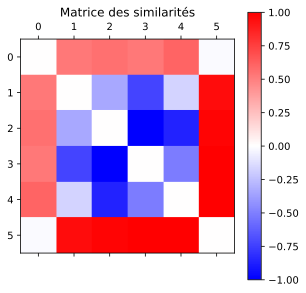

In [6]:
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

def disp_matrix(path:str='files/') -> None:
    D=dist_matrix()
    normalise(D) # Renormalisation pour un affichage plus lisible

    plt.matshow(D,cmap='bwr')
    plt.title('Matrice des similarités')
    plt.colorbar()
    plt.show()
    
    return None

disp_matrix()

## Génération d'un dendorgamme

Construction de la matrice de distances :   0%|          | 0/21 [00:00<?, ?it/s]

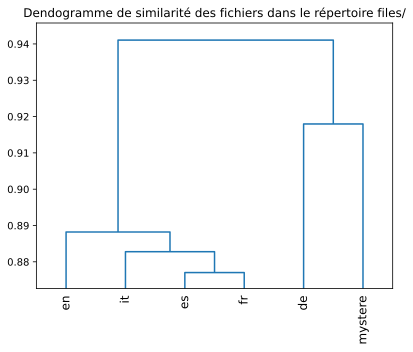

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def disp_dendogram(path:str='files/') -> None:
    D = dist_matrix(path)
    linkage_matrix = linkage( squareform( D ) )
    dend = dendrogram(linkage_matrix,labels=[file.name.split('.')[0] for file in scandir(path)],leaf_rotation=90)
    
    minimum = 1
    n=D.shape[0]
    for i in range(n): # On calcule les valeurs extrêmes
        for j in range(i):
            if D[i,j] < minimum:
                minimum = D[i,j]
                
    maximum = np.max(dend['dcoord'])

    plt.ylim(.995*minimum,1.005*maximum)
    plt.title("Dendogramme de similarité des fichiers dans le répertoire {}".format(path))
    plt.show()
    
    return None

disp_dendogram()